# PMAP Demographic Feature Engineering
Created: January 11, 2023

This notebook generates demographic features of CHF hospital stays w/ ICU.

Author: Vina Ro

In [60]:
# Import packages
import numpy as np
import pandas as pd
import time as time
import os
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from datetime import datetime

In [61]:
# Set filepath
file_path = Path('PMAP_Comorbidity.ipynb').resolve()
data_path = file_path.parent.parent.parent.parent.parent.joinpath('Data/jbergma8/IRB_271579_Faraday/IRB-271579-v3-DEID-220607-no-ptsd')

In [62]:
# Import data
patient               = pd.read_csv(data_path / 'patient.csv')
CHF_unq_idx_icu_stays = pd.read_csv('CHF_unq_idx_icu_stays.csv', parse_dates = ['hosp_admsn_time','hosp_disch_time','in_time','out_time'])

In [63]:
merged_df = pd.merge(left = CHF_unq_idx_icu_stays, right = CHF_patient[['osler_sid','pat_status','gender','first_race','birth_year']], how = 'left', on = 'osler_sid')

# Generating the age column: birth years with 1900 are encoded for ages > 90 due to HIPAA regulations.
merged_df['age'] = np.where(merged_df.birth_year == 1900, 90, merged_df.hosp_admsn_time.dt.year - merged_df.birth_year)

# Cleaning the dataframe column names
merged_df.rename(columns = {'first_race':'race'}, inplace = True)
merged_df['race'] = merged_df['race'].replace({'Am Indian': 'Indian'})

In [64]:
df_demo_features = pd.get_dummies(merged_df, columns = ['pat_status','gender','race'])
df_demo_features.to_csv('demographic_features.csv', index = False)

# Data Viz

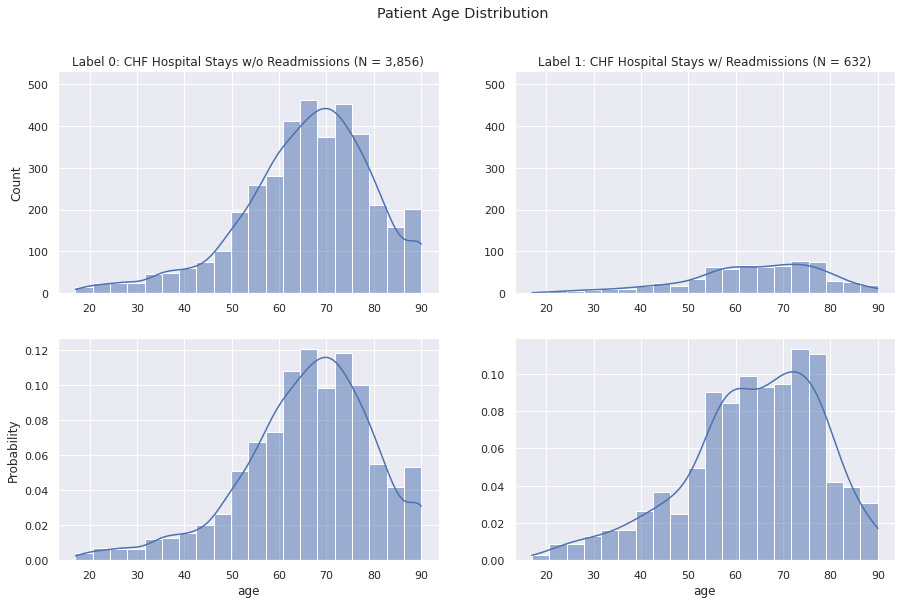

Mean of ages for label 0: 65.93343856879768
Median of ages for label 0: 67.0
STD of ages for label 0: 13.913455811569651
Mean of ages for label 1: 63.78165938864629
Median of ages for label 1: 66.0
STD of ages for label 1: 14.507223942352043


In [65]:
merged_df_label_0 = merged_df[merged_df.labels == 0]
merged_df_label_1 = merged_df[merged_df.labels == 1]

sns.set_theme()
plt.figure(figsize=(15,9))

plt.subplot(2,2,1)
sns.histplot(data=merged_df_label_0, x="age", kde=True, bins = 20)
plt.title('Label 0: CHF Hospital Stays w/o Readmissions (N = 3,856)')
plt.xlabel('')
plt.ylim([0, 530])

plt.subplot(2,2,2)
sns.histplot(data=merged_df_label_1, x="age", kde=True, bins = 20)
plt.xlabel('')
plt.ylabel('')
plt.ylim([0, 530])
plt.title('Label 1: CHF Hospital Stays w/ Readmissions (N = 632)')

plt.subplot(2,2,3)
sns.histplot(data = merged_df_label_0, x="age", kde=True, bins = 20, stat='probability')
#plt.ylim([0, 452])

plt.subplot(2,2,4)
sns.histplot(data = merged_df_label_1, x="age", kde=True, bins = 20, stat='probability')
plt.ylabel('')
#plt.ylim([0, 452])

plt.suptitle('Patient Age Distribution')
plt.show()

print('Mean of ages for label 0: ' + str(merged_df_label_0.age.mean()))
print('Median of ages for label 0: ' + str(merged_df_label_0.age.median()))
print('STD of ages for label 0: ' + str(merged_df_label_0.age.std()))
print('Mean of ages for label 1: ' + str(merged_df_label_1.age.mean()))
print('Median of ages for label 1: ' + str(merged_df_label_1.age.median()))
print('STD of ages for label 1: ' + str(merged_df_label_1.age.std()))